# **Random Forest Algortm**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value

#Traning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

## Import Data

In [2]:
df = pd.read_csv("../data/house_price.csv", index_col="ID")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


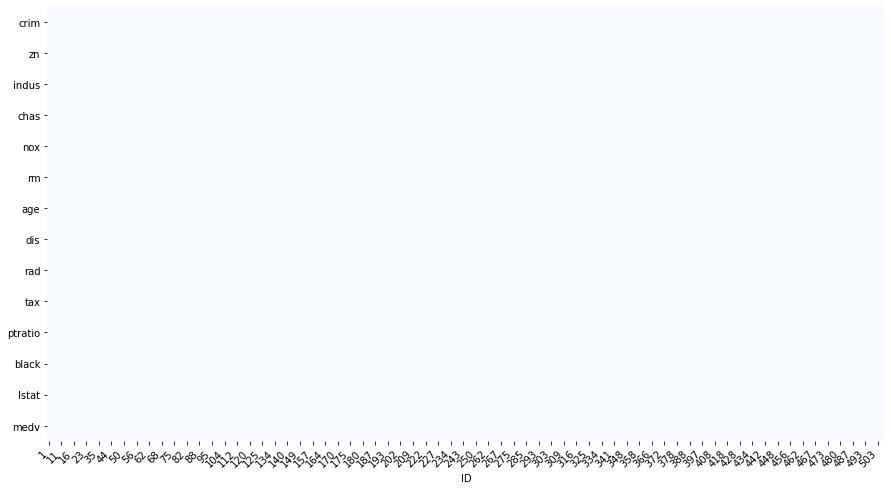

In [3]:
plot_missing_value(df)

## Split Data

In [4]:
X = df.drop(columns=["medv"])
y = df["medv"]

#karna kita prediksi regresi bukan clasifikasi maka data splitnya suffle split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

## Traning

In [5]:
X_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [6]:
gsp.rf_params

{'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}

- n estimator = berapa banyak pohon yang ingin dibuat
- max depth brp banyak dicios yang mw di buat
- max features brp banyak pembagian data terhadap target, karna realita data x terhadap y sangat banyak
- berapa banyak batas daun/percabangan yang ingin di buat

In [7]:
preprocesor = ColumnTransformer([
    ("numeric", num_pipe(),['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 
                            'rad', 'tax', 'ptratio', 'black', 'lstat']),
    ("categoric",cat_pipe(), ['chas'])
])

pipeline = Pipeline([
    ("prep", preprocesor),
    ("algo", RandomForestRegressor(n_jobs=-1, random_state=42))
])

#Tuning
model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train),  model.score(X_test, y_test), model.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 50, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9796825791444227 0.9131952055120968 0.8423714770450016


## Scaling bisa membantu SVM Dan KNN tetapi RAW Tidak

Karna Scaling tidak mempengaruhi algoritma berbasis pohon. tapi RF bisa melakukan feature Importance

## Feature Importance

### **Mean Loss Decrease**
Kita akan melihat rata rata pengurangan eoror(loss) yang di kontribusikan oleh tiap fitur<br>
Untuk kasus klasifikasi, loss yang dipakai adalah```gini Impurity```,jadi sering disebut juga ```mean Impurity decrease```<br>
Untuk kasus regresi, loss yang dipakai adalah MSE, mungkin bisa disebut ```mean MSE decrease```? <br>
boleh di cek tool tip dari random forest, loss yang di masukkan adalah ```criterion``` <br><br>
```Semakin besar loss yang berhasil di turunkan oleh suatu fitur maka semakin penting fitur tersebut```

In [8]:
from jcopml.feature_importance import mean_loss_decrease

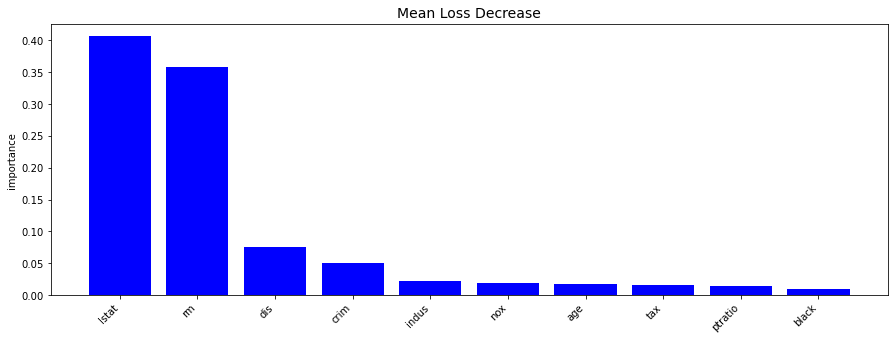

In [11]:
df_imp = mean_loss_decrease(X_train, model, plot=True, topk=10)

### **Mean Score Decrease** 
model agnostik(moel apapun bisa baik tree atau pun svm) <br>
```Kita acak beberapa variabel dan liat beberapa pengurangan score yang terjadi. Semakin besar penurunan score artinya fitur semakin penting ```

In [12]:
from jcopml.feature_importance import mean_score_decrease

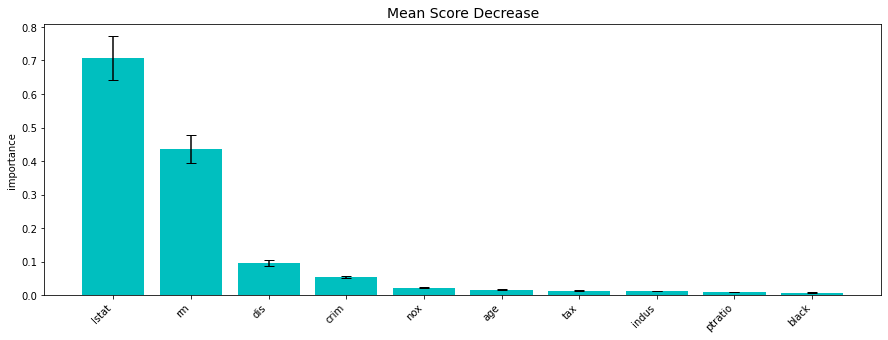

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)